C:\Users\moose\OneDrive\Documents\GitHub\Data-Augmentation-Using-Generative-Adversarial-Networks\Handwritten Digits Generator With a GAN
['cityscapes']
[Epoch 0/10]  [D loss: 1.891393, acc:  46%] [G loss: 27.862076] time: 0:12:59.380229


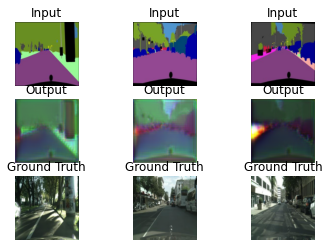

[Epoch 1/10]  [D loss: 0.310649, acc:  48%] [G loss: 12.319003] time: 0:24:25.423250


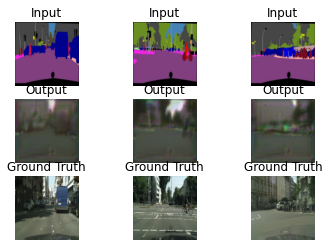

[Epoch 2/10]  [D loss: 0.324080, acc:  41%] [G loss: 11.707140] time: 0:35:53.726822


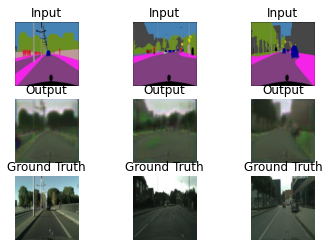

[Epoch 3/10]  [D loss: 0.271683, acc:  66%] [G loss: 11.596334] time: 0:47:16.740675


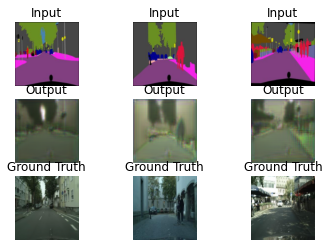

[Epoch 4/10]  [D loss: 0.230755, acc:  64%] [G loss: 11.424354] time: 0:58:46.900624


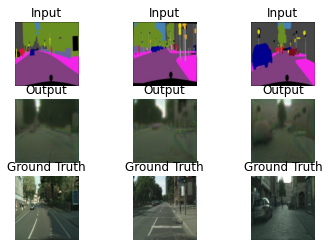

In [ ]:
from __future__ import print_function, division
import pandas as pd
import scipy
from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from skimage import transform
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
import os
from imageio import imread

#You can use this to find the directory for this file
print(os.getcwd())

#Sourab
#input_dir = ""

#Arens
input_dir = "C:/Users/moose/OneDrive/Documents/GitHub/input"
print(os.listdir(input_dir))


def load_data(dataset_name, batch_size=1, is_val=False):
    data_type = "train" if not is_val else "val"
    path = glob(input_dir + '/%s/%s/%s/*' % (dataset_name, dataset_name, data_type))

    batch_images = np.random.choice(path, size=batch_size)
    img_res = (128, 128)
    imgs_A = []
    imgs_B = []
    for img_path in batch_images:
        img = imread(img_path)

        h, w, _ = img.shape
        _w = int(w / 2)
        # because in the edges2shoes and maps dataset the input image comes before the ground truth.
        if (dataset_name == "edges2shoes" or dataset_name == "maps"):
            img_A, img_B = img[:, _w:, :], img[:, :_w, :]
        else:
            img_A, img_B = img[:, :_w, :], img[:, _w:, :]
            

        
        # decreasing the resolution
        img_A = transform.resize(img_A, img_res)  # Ground Truth image
        img_B = transform.resize(img_B, img_res)  # Input image

        # If training => do random flip , this is a trick to avoid overfitting
        if not is_val and np.random.random() < 0.5:
            img_A = np.fliplr(img_A)
            img_B = np.fliplr(img_B)

        imgs_A.append(img_A)
        imgs_B.append(img_B)

#     imgs_A = np.array(imgs_A) / 127.5 - 1.  # normalizing the images
#     imgs_B = np.array(imgs_B) / 127.5 - 1.
    

    imgs_A = (imgs_A)/np.max(imgs_A) - 1
    imgs_B = (imgs_B)/np.max(imgs_B) - 1

    return imgs_A, imgs_B


def load_batch(dataset_name, batch_size=1, is_val=False):
    data_type = "train" if not is_val else "val"
    path = glob(input_dir + '/%s/%s/%s/*' % (dataset_name, dataset_name, data_type))
    n_batches = batch_size
    img_res = (128, 128)
    for i in range(n_batches - 1):
        batch = path[i * batch_size:(i + 1) * batch_size]
        imgs_A, imgs_B = [], []
        for img in batch:
            img = imread(img)
            h, w, _ = img.shape
            half_w = int(w / 2)
            # because in the edges2shoes and maps dataset the input image comes before the ground truth.
            if (dataset_name == "edges2shoes" or dataset_name == "maps"):
                img_A, img_B = img[:, half_w:, :], img[:, :half_w, :]
            else:
                img_A, img_B = img[:, :half_w, :], img[:, half_w:, :]
            img_A = transform.resize(img_A, img_res)  # Ground truth image
            img_B = transform.resize(img_B, img_res)  # input image

            # when training => do random flip , this is a trick to avoid overfitting
            if not is_val and np.random.random() > 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)
            
        # normalizing the images
#         imgs_A = np.array(imgs_A) / 127.5 - 1.
#         imgs_B = np.array(imgs_B) / 127.5 - 1.
        
        imgs_A = (imgs_A)/np.max(imgs_A) - 1
        imgs_B = (imgs_B)/np.max(imgs_B) - 1

        yield imgs_A, imgs_B


# def imread(path):
#    return scipy.misc.imread(path, mode='RGB').astype(np.float)

def build_generator():
    """U-Net Generator"""

    def conv2d(layer_input, filters, f_size=4, bn=True):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])  # skip connection
        return u

    d0 = Input(shape=img_shape)

    # Downsampling
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf * 2)
    d3 = conv2d(d2, gf * 4)
    d4 = conv2d(d3, gf * 8)
    d5 = conv2d(d4, gf * 8)
    d6 = conv2d(d5, gf * 8)
    d7 = conv2d(d6, gf * 8)

    # Upsampling
    u1 = deconv2d(d7, d6, gf * 8)
    u2 = deconv2d(u1, d5, gf * 8)
    u3 = deconv2d(u2, d4, gf * 8)
    u4 = deconv2d(u3, d3, gf * 4)
    u5 = deconv2d(u4, d2, gf * 2)
    u6 = deconv2d(u5, d1, gf)

    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(d0, output_img)


def build_discriminator():
    # a small function to make one layer of the discriminator
    def d_layer(layer_input, filters, f_size=4, bn=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    img_A = Input(shape=img_shape)
    img_B = Input(shape=img_shape)

    # Concatenate image and conditioning image by channels to produce input
    combined_imgs = Concatenate(axis=-1)([img_A, img_B])

    d1 = d_layer(combined_imgs, df, bn=False)
    d2 = d_layer(d1, df * 2)
    d3 = d_layer(d2, df * 4)
    d4 = d_layer(d3, df * 8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([img_A, img_B], validity)


# Input shape
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)

# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2 ** 4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                 loss_weights=[1, 100],
                 optimizer=optimizer)


def show_images(dataset_name, epoch, batch_i):
    r, c = 3, 3

    imgs_A, imgs_B = load_data(dataset_name, batch_size=3, is_val=True)
    fake_A = generator.predict(imgs_B)

    gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Input', 'Output', 'Ground Truth']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    
    for i in range(r):
        for j in range(c):
            gen_imgs[cnt] *= 1.0/np.max(gen_imgs[cnt])
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[i])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    plt.close()


def train(dataset_name, epochs, batch_size=1, show_interval=10):
    start_time = datetime.datetime.now()

    # Adversarial loss ground truths
    valid = np.ones((batch_size,) + disc_patch)
    fake = np.zeros((batch_size,) + disc_patch)

    for epoch in range(epochs):
        for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(dataset_name, batch_size)):
            #  Train Discriminator
            print("Batch: ",batch_i+1,"/",batch_size, end='\r')
            
            # Condition on B and generate a translated version
            fake_A = generator.predict(imgs_B)            
            
            # Train the discriminators (original images = real / generated = Fake)
            d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
            d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator
            g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

            elapsed_time = datetime.datetime.now() - start_time

        # Plot the progress
        if epoch % 1 == 0:
            print("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,

                                                                                     d_loss[0], 100 * d_loss[1],
                                                                                     g_loss[0],
                                                                                     elapsed_time))
        # If at show interval => show generated image samples
        if epoch % show_interval == 0:
            show_images(dataset_name, epoch, batch_i)


train("cityscapes", epochs=10, batch_size=32, show_interval=1)


In [ ]:
cnt = 0
def show_images(dataset_name, epoch, batch_i):
    r, c = 3, 3

    imgs_A, imgs_B = load_data(dataset_name, batch_size=3, is_val=True)
    fake_A = generator.predict(imgs_B)
    print(imgs_B.shape)
    gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

    # Rescale images 0 - 1
    print(gen_imgs.shape)
    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Input', 'Output', 'Ground Truth']
#     fig, axs = plt.subplots(r, c)
    cnt = 0
    print(np.max(gen_imgs[cnt]), np.min(gen_imgs[cnt]))
    print(gen_imgs[cnt].shape)
    gen_imgs[cnt] = (gen_imgs[cnt] - 1)/(np.max(gen_imgs[cnt])-1)
    print(np.max(gen_imgs[cnt]), np.min(gen_imgs[cnt]))
    plt.imshow(gen_imgs[cnt],cmap = 'plasma')
#     for i in range(r):
#         for j in range(c):
# #             print(max(gen_imgs[cnt]),min(gen_imgs[cnt]))
#             axs[i, j].imshow(gen_imgs[cnt])
#             axs[i, j].set_title(titles[i])
#             axs[i, j].axis('off')
#             cnt += 1
    plt.show()
    plt.close()

show_images("cityscapes", 0, -1)